In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import multivariate_normal
import seaborn as sns

from sklearn.datasets import make_spd_matrix
from sklearn.mixture import GaussianMixture

plt.rcParams["axes.grid"] = False

In [2]:
def GMM(X, k, num_iterations=50):
    """
    cluster the data points into k clusters using a Gaussian Mixture Model (GMM)
    
    Parameter
    ---------
    X: numpy array
       A dataset of shape (m,n), where m is the number of datapoints, n is the number of features
       
    k: int
       The number of desired clusters
       
    num_iterations:int   
       The number of iterations in which the model is trained.
       
    Returns
    -------
    The cluster labels of each point in the dataset
    """
    
    m,n = X.shape
    eps = 1e-8
    
    #Initialize mixture coefficients:
    mix_coef = np.ones(k)/k
    
    #Initialize cluster means randomly from data:
    means_idx = np.random.choice(range(m), size=k, replace=False) 
    means = X[means_idx]
    
    #Initialize covariance matrix for each cluster:
    cov = np.empty((k,n,n))
    for i in range(k):
        cov[i,:,:] = make_spd_matrix(n)
        
    #Start iterating:
    for _ in range(num_iterations):
        #Expectation Step:
        likelihood = np.empty((m,k)) #P(X|yk)
        for i in range(k):
            likelihood[:,i] = multivariate_normal.pdf(x=X, mean=means[i], cov=cov[i])
            
        responsibilities = (likelihood*mix_coef)/ (np.sum(likelihood*mix_coef, axis=1).reshape((m,1)) + eps)
        
        #Maximization Step:
        Nk = np.sum(responsibilities+eps, axis=0) #Total Weight per cluster.
        mix_coef = Nk/m
        for i in range(k):
            means[i] = np.sum(responsibilities[:,i].reshape((m,1))*X, axis=0)/Nk[i]
            cov[i] = np.dot((responsibilities[:,i].reshape((m,1))*(X-means[i])).T,(X-means[i]))/Nk[i]

    return np.argmax(responsibilities, axis=1).reshape((m,1))

### Data Generation:

In [3]:
def generate_clusters(n_samples_per_cluster=100):
    #Define the mean points for each of the systhetic cluster centers
    t_means = [[8.4, 8.2], [1.4, 1.6], [2.4, 5.4], [6.4, 2.4]]

    #For each cluster center, create a Positive semidefinite convariance matrix
    t_covs = [make_spd_matrix(2) for i in range(len(t_means))]
    
    #Generate data:
    X = [[np.random.multivariate_normal(mean, cov, n_samples_per_cluster)] for mean, cov in zip(t_means,t_covs)]
    
    X = np.array(X).reshape(n_samples_per_cluster*4, 2)
    np.random.shuffle(X)
    print("Dataset shape:", X.shape)
    return X

Dataset shape: (400, 2)


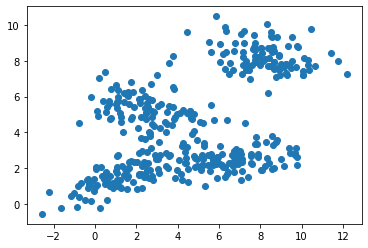

In [4]:
X = generate_clusters()
plt.scatter(X[:,0], X[:,1])
plt.show()

### Model Testing:

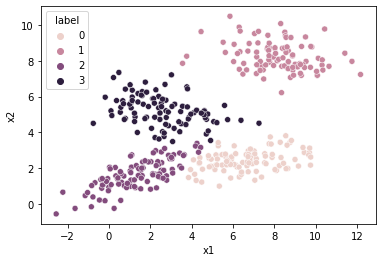

In [6]:
labels = GMM(X, 4)
df = pd.DataFrame(X, columns=["x1","x2"])
df["label"] = labels

sns.scatterplot(data=df, x="x1", y="x2", hue="label");

### Compared with Scikit-learn implementation:

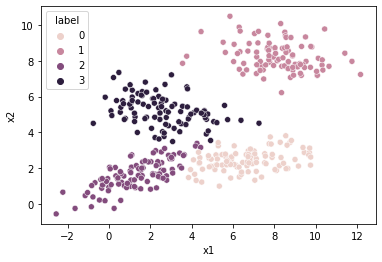

In [7]:
sklearnGMM = GaussianMixture(4)
labels = sklearnGMM.fit_predict(X)

df = pd.DataFrame(X, columns=["x1","x2"])
df["label"] = labels

sns.scatterplot(data=df, x="x1", y="x2", hue="label");